# 학습목표
- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 하기

# 목차

### 노드 따라가기

- 필요한 모듈과 사진을 준비하기
- 시맨틱 세그멘테이션 다뤄보기
    - 세그멘테이션 결과를 원래 크기로 복원하기
    - 배경 흐리게 하기
    - 흐린 배경과 원본 영상 합성하기
- 문제점 찾기

### 프로젝트

- 문제점 해결해보기
    - 마스크 범위 수정하기
    - 마스크에 블러 효과 주기
    - 영상 분리하기
    - 영상 합성하기
    - 결과 비교하기
- 여러가지 사진으로 시도하기
- 크로마키 합성 하기
- 인물 모드 문제점 찾기
    - 세그멘테이션을 이용한 인물모드의 한계
    - 피사계심도 이해하기
    - 스마트폰으로는 아웃포커싱이 불가능한가?
    - 접근방향
- 해결 방안 순서도

AIFFEL 유상민님 코드를 보면서 진행함.
https://github.com/ysmNew/Aiffel/blob/main/Ex08/Segmentation.ipynb

# 노드 따라가기
## 필요한 모듈과 사진을 준비하기

이미지 출처 : pixabay

In [3]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [7]:
car_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/squad_car.jpg'
car_orig = cv2.imread(car_img_path) 
print (car_orig.shape)

(346, 640, 3)


# 시맨틱 세그멘테이션 다뤄보기

In [8]:
# DeepLab 모델. 구글에서 제공하는 모델 구조 그대로 -> DeepLabModel 클래스

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

print('done')

done


In [9]:
# define model and download & load pretrained weight

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab/human_segmentation/models
model loaded successfully!


(346, 640, 3) (277, 513, 3) 7


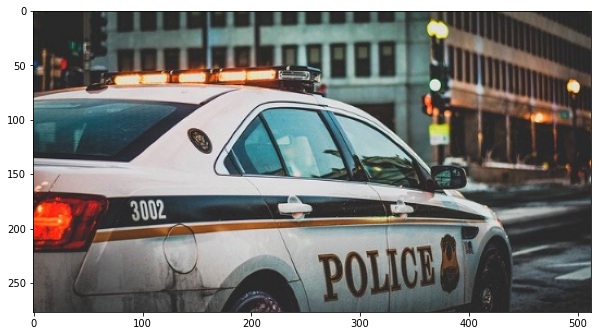

In [10]:
# 준비한 이미지를 네트워크에 입력, 사진을 필요한 만큼 축소해준다

car_resized, car_map = MODEL.run(car_orig)
print (car_orig.shape, car_resized.shape, car_map.max())

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(car_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
# 7번이 뭔지 확인

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
LABEL_NAMES[7]

'car'

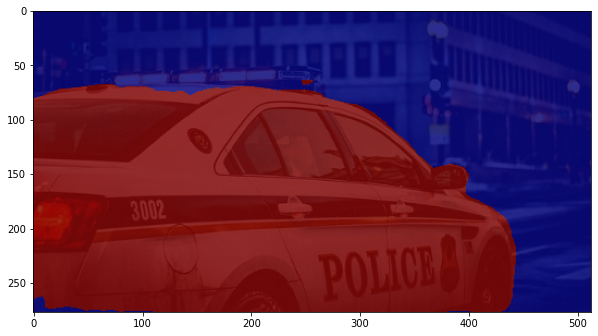

In [12]:
# 시맨틱 세그멘테이션 : 차와 차가 아닌걸 다른 색으로 구분

car_show = car_resized.copy() # 리사이즈 이미지 저장
car_map = np.where(car_map == 7, 7, 0) # 예측 중 픽셀값이 7 인 차만 추출
car_mask = car_map * (255/car_map.max()) # 255 normalization
# car_max.max() = 7 이므로 car_map / car_map.max()는 0과 1로 이루어진 행렬
# 255를 곱했으므로 차인 부분은 255, 차가 아닌 부분은 0인 마스크가 만들어진다
car_mask = car_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(car_mask, cv2.COLORMAP_JET)
car_show = cv2.addWeighted(car_show, 0.2, color_mask, 0.8, 0.0)

fig = plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(car_show, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 결과를 원래 크기로 복원하기

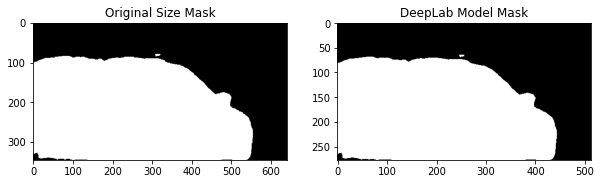

In [13]:
# 차만 보이는 마스크를 원본 사이즈로 리사이징
car_mask_up = cv2.resize(car_mask, car_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, car_mask_up = cv2.threshold(car_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 8))

ax = plt.subplot(1,2,1)
plt.imshow(car_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(car_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 배경 흐리게 하기

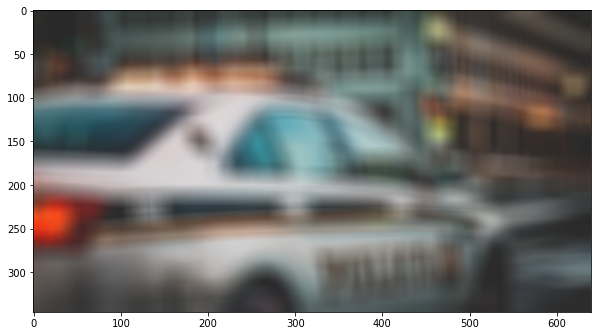

In [14]:
# blur() 함수를 이용해서 배경을 흐리게 만들기

car_orig_blur = cv2.blur(car_orig, (25,25)) #(25,25)은 blurring  kernel size를 뜻합니다.

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(car_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

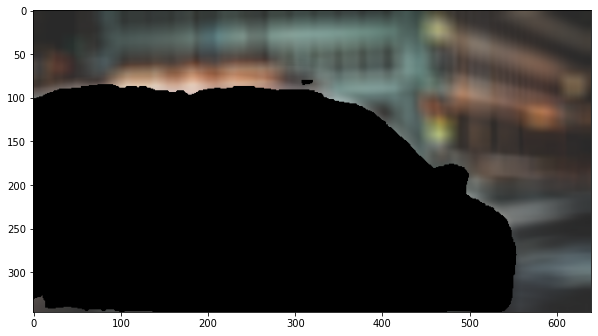

In [15]:
# 세그멘테이션 마스크를 이용해서 배경만 추출

car_mask_color = cv2.cvtColor(car_mask_up, cv2.COLOR_GRAY2BGR)
car_bg_mask = cv2.bitwise_not(car_mask_color) 
# 마스크 뒤집어서, 차는 0, 배경은 255인 마스크 만들기
car_bg_blur = cv2.bitwise_and(car_orig_blur, car_bg_mask) 
# 두 이미지 비트연산
# 하나라도 0이면 0(검은 마스크) 출력, 0이 아니면 최종 판단(이미지) 출력

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(car_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐린 배경과 원본 영상 합성하기

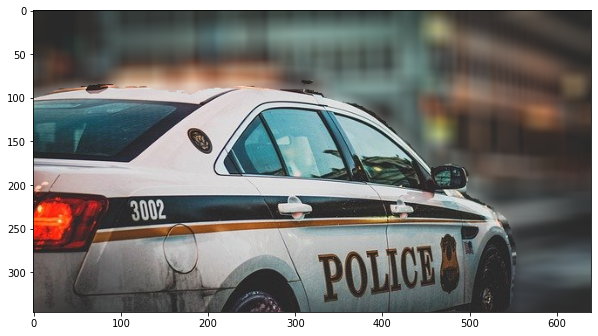

In [16]:
# 배경 영상과 자동차 영상을 합치기

car_concat = np.where(car_mask_color==255, car_orig, car_bg_blur)
# 마스크에서 255인 부분(차)은 car_origin, 아닌 부분은 car_bg_blur 를 사용

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(car_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 찾기

1. 사라져버린 경광등
2. 깔끔하지 못한 경계선

# 프로젝트
## 문제점 해결해보기

### 마스크 범위 수정하기

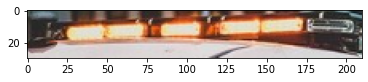

In [17]:
#마스크에 포함되지 않는 경광등 부분 잘라내서 확인

temp = car_resized[50:80,50:260].copy()
plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

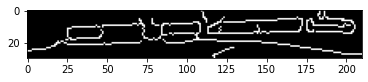

In [18]:
# 외곽선만 따내기

blur = cv2.GaussianBlur(temp, ksize=(7,7), sigmaX=0)
ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
edged = cv2.Canny(blur, 10, 250)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

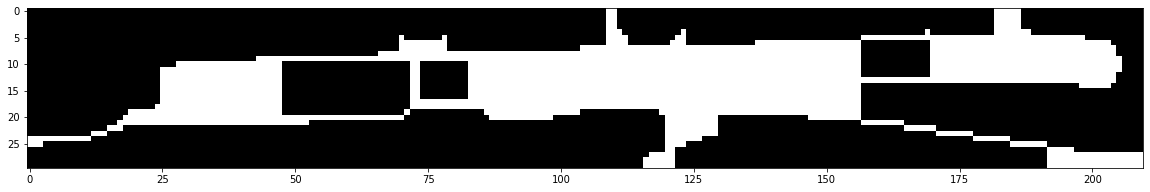

In [19]:
# 닫힌 공간 찾기

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(closed, cv2.COLOR_BGR2RGB))
plt.show()

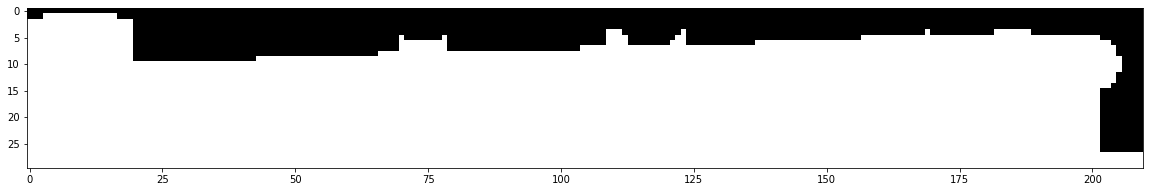

In [20]:
# 그래도 안 채워진 부분은 손으로 한땀한땀 채움

closed[10:, :157]=255
closed[5:, 157:202]=255
closed[:4, :]=0
closed[2:, :20]=255
closed[1:, 3:17]=255

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(closed, cv2.COLOR_BGR2RGB))
plt.show()

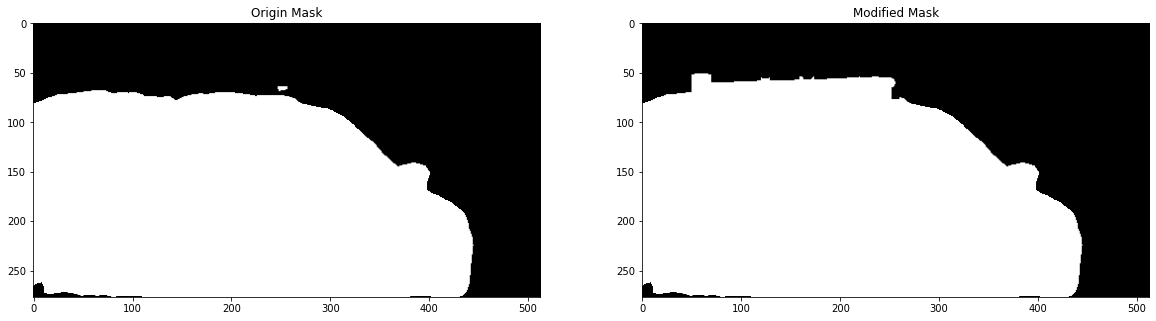

In [21]:
fig = plt.figure(figsize=(20, 15)) 

# 원래 마스크
ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(car_mask, cv2.COLOR_BGR2RGB))
ax.set_title('Origin Mask')

# 수정된 부분 덧붙인 마스크 생성
car_mask2 = car_mask.copy()
car_mask2[50:80,50:260] = closed

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(car_mask2, cv2.COLOR_BGR2RGB))
ax.set_title('Modified Mask')

plt.show()

car 마스크 크기: (277, 513)


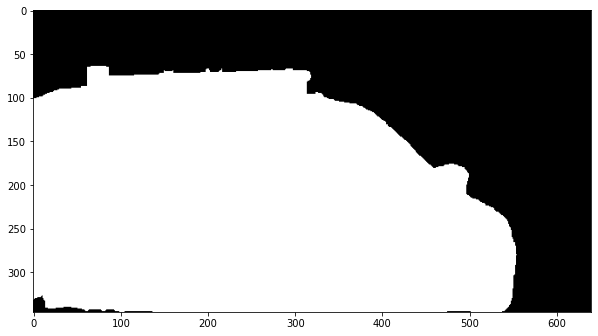

In [22]:
# 리사이징 한 마스크 출력

car_mask2_up = cv2.resize(car_mask2, car_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, car_mask2_up = cv2.threshold(car_mask2_up, 128, 255, cv2.THRESH_BINARY)

print(f'car 마스크 크기: {car_mask2.shape}')

fig = plt.figure(figsize=(10, 8))

plt.imshow(car_mask2_up, cmap=plt.cm.binary_r)

plt.show()

### 마스크에 블러 효과 주기

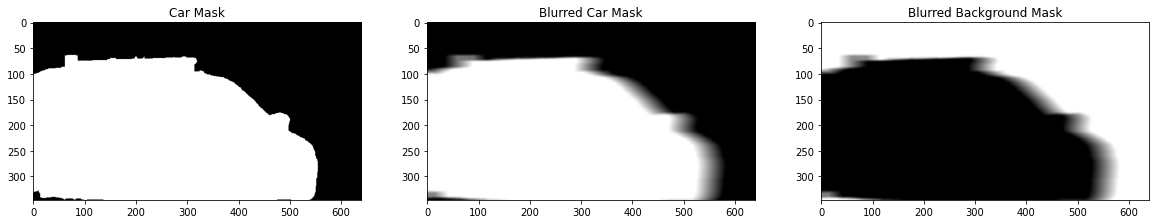

In [23]:
# 차만 보이는 마스크를 원본 이미지와 같은 채널로 변환
car_mask2_3C = np.repeat(np.expand_dims(car_mask2_up, axis=2), 3, axis=2).astype(np.uint8)
# 한 픽셀에 하나의 숫자 0, 255만 나타나있는 car_mask2_up 매트릭스를
# 한 픽셀에 [0,0,0], [255,255,255]인 텐서로 바꿔주는 역할

# 차만 보이는 마스크 블러 처리
car_Bmask = (cv2.blur(car_mask2_3C, (55, 5))/255).astype(np.float32)
# blur 함수로 픽셀들의 값이 [0,225] 사이의 값으로 부드럽게 바뀌고
# 255로 나눠주었으므로 [0,1] 사이의 값이 됨


# 마스크를 리버스해서 배경만 보이는 마스크 만들기
bg_Bmask = 1 - car_Bmask
# 값들이 float라서 노드처럼 bitwise 연산을 할 수는 없고
# 대신 1에서 마스크의 값을 빼주면 완벽하게 뒤집힌 마스크를 얻을 수 있음

fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,3,1)
plt.imshow(car_mask2_up, cmap=plt.cm.binary_r) # 차만 보이는 마스크
ax.set_title('Car Mask')

ax = plt.subplot(1,3,2)
plt.imshow(car_Bmask, cmap=plt.cm.binary_r) # 차만 보이는 블러 마스크 
ax.set_title('Blurred Car Mask')

ax = plt.subplot(1,3,3)
plt.imshow(bg_Bmask, cmap=plt.cm.binary_r) # 배경만 보이는 블러 마스크  
ax.set_title('Blurred Background Mask')

plt.show()

### 영상 분리하기

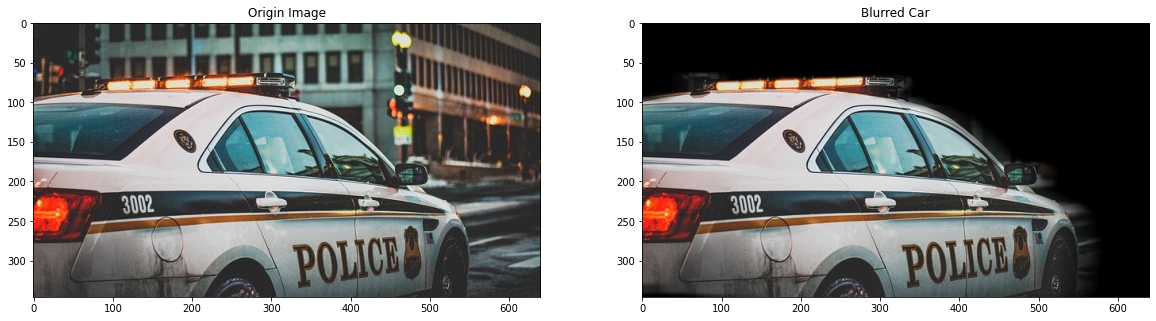

In [24]:
# 차만 보이는 마스크 * 원본이미지 로
# 경계면이 블러 처리된 차 얻기

car_image_Hblur = car_Bmask*car_orig.astype(np.float32)
# 이제 두 텐서를 원소별 곱연산 해주면, 경계는 원본의 픽셀값이 0.x 배로 감소해서 연해짐
# 차부분은 1 이므로 원본 이미지의 픽셀값이 그대로이므로 흐려지지 않음


fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(car_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Origin Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(car_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Car')

plt.show()

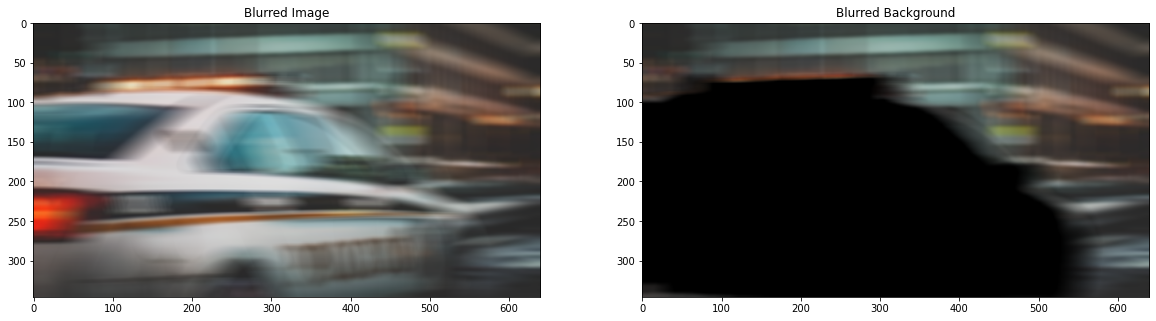

In [25]:
# blur() 함수를 이용해서 배경을 흐리게 만들기

car_orig_Hblur = cv2.blur(car_orig, (55,5)) #(13,13)은 blurring  kernel size를 뜻합니다.

# 배경만 보이는 마스크 * 블러이미지 로
# 전체가 블러 처리된 배경 얻기

bg_image_Hblur = bg_Bmask*car_orig_Hblur.astype(np.float32)

fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(car_orig_Hblur, cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(bg_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Background')

plt.show()

### 영상 합성하기

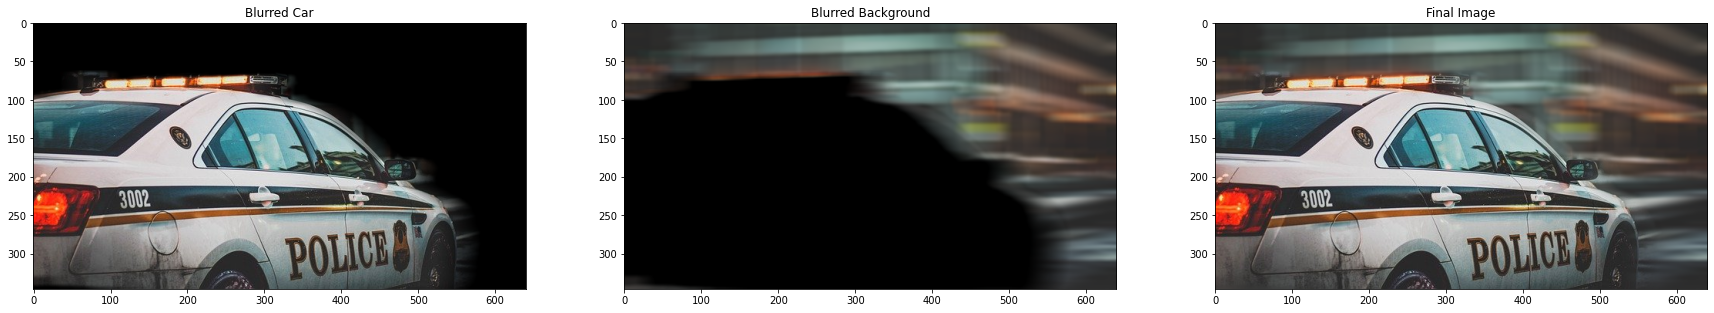

In [26]:
# 두 이미지를 합해서 최종 이미지 획득

final_image = (car_image_Hblur+bg_image_Hblur).astype(np.uint8)

fig = plt.figure(figsize=(30, 20)) 

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(car_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Car')

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(bg_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Background')

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
ax.set_title('Final Image')

plt.show()

### 결과 비교하기

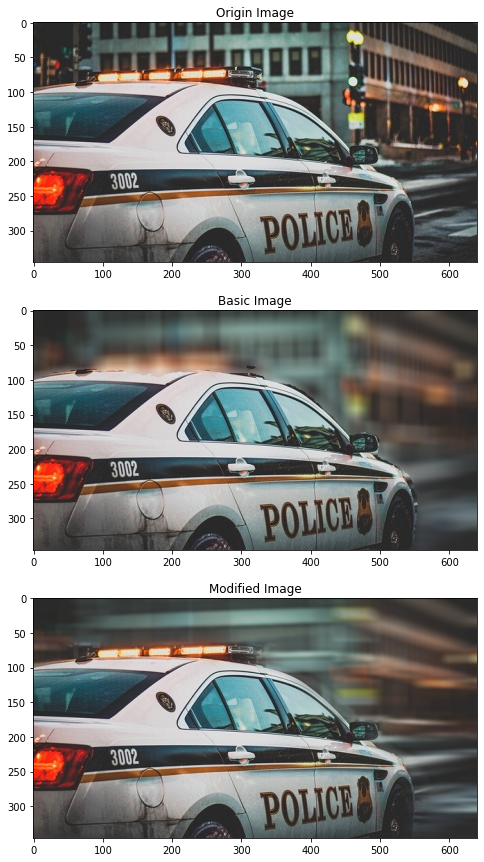

In [27]:
fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(car_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Origin Image')

ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(car_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Basic Image')

ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
ax.set_title('Modified Image')

plt.show()